In [1]:
import numpy as np
import pandas as pd
import seaborn as sbs
import matplotlib.pyplot as plt
from pathlib import Path
import networkx as nx
import seaborn as sbs
import random
%matplotlib inline

In [2]:
# Read the L matrix and construct a dataframe with 2 indices country and sector
df_lev = pd.read_csv('/project_data/data_asset/Leontief_inverse_world.csv',low_memory=False,index_col=[0,1],skiprows=[0,1])
# Remap the column names
df_lev.columns = df_lev.index.get_level_values(1).values

    
df_lev
#df_lev.loc['DEU']
#np.sum(df_lev.drop(columns=['All non-essential']).loc['DEU'].values,axis=1)
#np.sum(df_lev.loc['DEU'].values,axis=1).shape
#df_lev.iloc[df_lev.index.get_level_values('region') == 'DEU',
#      df_lev.columns.get_level_values('region') == 'DEU']

01T03     05T06        09     10T12     13T15  \
region sector                                                                
ARG    01T03              1.187808  0.003435  0.004858  0.462932  0.052188   
       05T06              0.033299  1.109050  0.103432  0.029109  0.025558   
       09                 0.006866  0.073401  1.069065  0.004406  0.002162   
       10T12              0.029088  0.002556  0.003002  1.063266  0.013079   
       13T15              0.005548  0.002929  0.003312  0.009684  1.249704   
...                            ...       ...       ...       ...       ...   
TUR    All non-essential  0.000050  0.000094  0.000125  0.000070  0.000082   
TWN    All non-essential  0.000050  0.000134  0.000175  0.000078  0.000080   
USA    All non-essential  0.000865  0.001306  0.001437  0.001095  0.001312   
VNM    All non-essential  0.000015  0.000024  0.000034  0.000022  0.000052   
ZAF    All non-essential  0.000055  0.000108  0.000139  0.000076  0.000078   

                                16     17T18        19     20T21        22  \
region sector                                                                
ARG    01T03              0.114517  0.034647  0.003493  0.023762  0.024679   
       05T06              0.026804  0.037720  0.522608  0.088302  0.055159   
       09                 0.002935  0.004113  0.035119  0.006616  0.005572   
       10T12              0.008994  0.011070  0.002389  0.010193  0.007014   
       13T15              0.007756  0.010227  0.002282  0.008996  0.015465   
...                            ...       ...       ...       ...       ...   
TUR    All non-essential  0.000084  0.000098  0.000110  0.000138  0.000148   
TWN    All non-essential  0.000105  0.000096  0.000100  0.000103  0.000160   
USA    All non-essential  0.001290  0.001714  0.001135  0.002295  0.002737   
VNM    All non-essential  0.000025  0.000028  0.000025  0.000042  0.000045   
ZAF    All non-essential  0.000099  0.000120  0.000137  0.000135  0.000164   

                          ...  All non-essential  All non-essential  \
region sector             ...                                         
ARG    01T03              ...           0.000019           0.000032   
       05T06              ...           0.000009           0.000017   
       09                 ...           0.000001           0.000002   
       10T12              ...           0.000015           0.000018   
       13T15              ...           0.000010           0.000364   
...                       ...                ...                ...   
TUR    All non-essential  ...           0.005392           0.006295   
TWN    All non-essential  ...           0.001084           0.000970   
USA    All non-essential  ...           0.005834           0.003438   
VNM    All non-essential  ...           0.000311           0.000372   
ZAF    All non-essential  ...           0.000657           0.001031   

                          All non-essential  All non-essential  \
region sector                                                    
ARG    01T03                       0.000011           0.000037   
       05T06                       0.000011           0.000021   
       09                          0.000001           0.000002   
       10T12                       0.000011           0.000034   
       13T15                       0.000004           0.000035   
...                                     ...                ...   
TUR    All non-essential           0.002856           0.000665   
TWN    All non-essential           0.000703           0.008691   
USA    All non-essential           0.003879           0.015666   
VNM    All non-essential           0.000135           0.005972   
ZAF    All non-essential           0.000452           0.001858   

                          All non-essential  All non-essential  \
region sector                                                    
ARG    01T03                       0.000048       1.426026e-05   
       05T06      

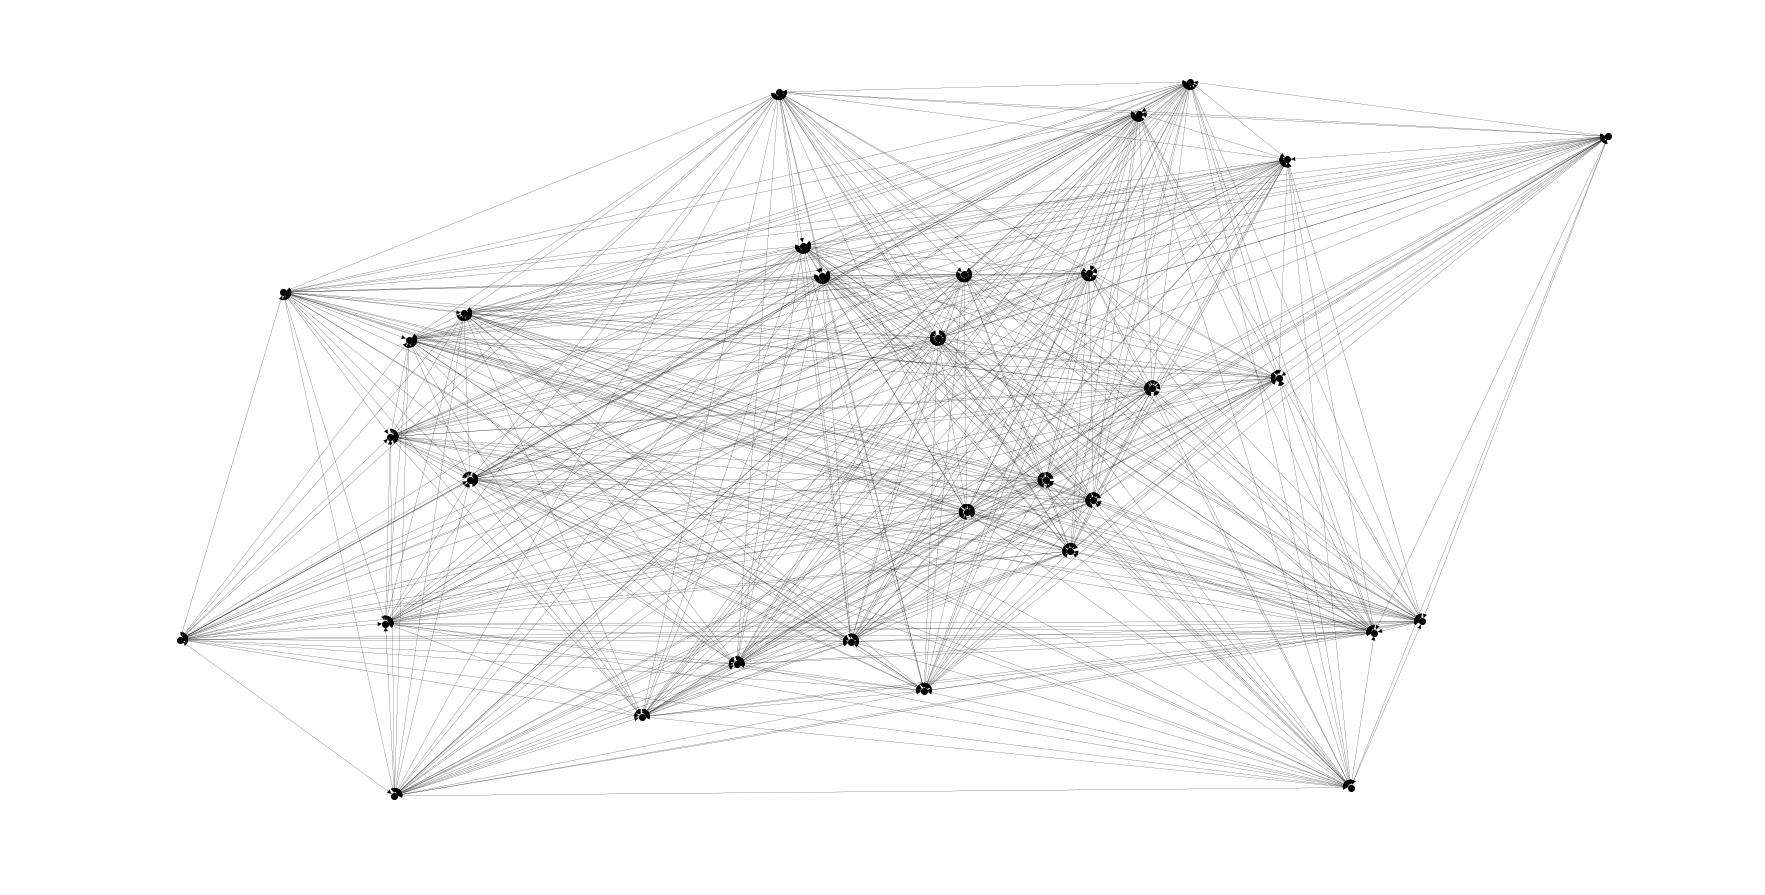

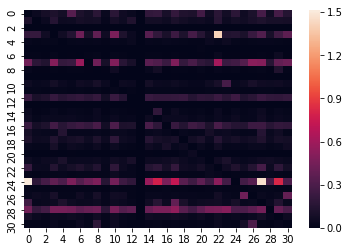

In [4]:
def build_influence_matrix(df):
    
    #G = nx.from_numpy_matrix(df.groupby(df.columns, axis=1).sum().values,create_using=nx.DiGraph) #Not very useful as we've got enriched node and edge attrs
    G = nx.DiGraph()
    
    list_unique_sectors = list(set(df.columns))
    G.add_nodes_from(list_unique_sectors)
    nx.set_node_attributes(G,lambda *x: np.mean(x),name='fn')
    for _node1, row in df.iterrows():
        # ignore self-loops for the moment
        _list_other_sectors = [_node for _node in list(row.keys()) if _node!=_node1]
        for _node2 in _list_other_sectors:
            G.add_edge(_node1,_node2)
            nx.set_edge_attributes(G,{(_node1,_node2):{'fn':lambda x: x*row[_node],'val':row[_node2]}})
        
        
    return G

visualize_graph = True

df = df_lev.loc['DEU']
G = build_influence_matrix(df.groupby(df.columns, axis=1).sum())#df.groupby(df.columns, axis=1).sum()

if visualize_graph:

    options = {
            'node_color': 'black',
            'node_size': 50,
            'line_color': 'grey',
            'linewidths': 0,
            'width': 0.1,}
    plt.figure(figsize=(24,12))
    nx.draw(G,pos=nx.random_layout(G),**options)
    plt.show()

    plt.figure()
    sbs.heatmap(nx.adjacency_matrix(G,weight='val').toarray())


In [5]:
class CellDynamics:
    
    def __init__(self,flow_graph = None,comp_model='graph'):
        '''
        what sort of graphs do we want to allow. Ideally Digraphs with node and edge with
        2 classes of attributes, funtion and value
        '''
        self.sim_graph = flow_graph
        self.clock = 0
        self.node_values ={}
        self.comp_model = comp_model
        for _node in self.sim_graph.nodes:
            self.node_values[_node] = []
        self.fit_type = None
            
    def sort_graph(self):
        # Topologically sort the graph
        try:
            self.sorted_nodes = list(nx.algorithms.dag.topological_sort(self.sim_graph))
            self.depr_sorting = False
        except:
            # in case of cycles, use pagerank to order nodes
            # Comment SDS: i thought it was just a random idea, but apparently there is some thinking along this line (https://github.com/zhenv5/breaking_cycles_in_noisy_hierarchies)
            pr = nx.pagerank(self.sim_graph)
            self.node_importance_scores = pr
            self.depr_sorting = True
            sorted_vals = sorted(pr.items(),key=lambda x:x[1],reverse=False)
            self.sorted_nodes = [_r[0] for _r in sorted_vals]
        
        
    
    def fit_params(self,node_values = {},fit_type='baseline'): 
        '''
        For the cases, where the edge attributes indicate dynamical relationships, solve the 
        dynamical system by setting exogeneous nodes to basevalues and let the flows propagate values to other nodes (fit_type baseline). 
        For ML functions, use fit()
        '''
        if (self.comp_model == 'graph'):
            self.sort_graph()
            self.fit_type = fit_type    
            for _node in list(node_values.keys()):
                self.sim_graph.nodes[_node][fit_type] =node_values[_node]
                self.node_values[_node].append(node_values[_node])
            self.propagate_influences(attr_name=fit_type,normalize=False)
            #self.fit_type = fit_type
        elif (self.comp_model == 'tensor'):
            self.sort_graph()
            self.fit_type = fit_type
            self.adj_mat = nx.adjacency_matrix(G,nodelist=self.sorted_nodes,weight='val').toarray()
            # Construct a vector of node values
            node_vec = []
            for _node in self.sorted_nodes:
                if _node in node_values.keys():
                    node_vec.append(node_values[_node])
                else:
                    node_vec.append(0)
            self.node_vec = np.array(node_vec,dtype=float)
            self.propagate_influences(attr_name=fit_type,normalize=False)
                    
    
    
    def reset_flows(self):
        '''
        reset all edge flows / attributes to be None
        '''
        pass
    
    def clock_tick(self,**kwargs): 
        '''
        Do the bookkeeping ops with the clock tick.
        '''
        self.reset_flows()
        self.clock += 1
        print('Tick tock %d'%(self.clock))
        self.propagate_influences()
        
    
    
    def propagate_influences(self,attr_name='val',normalize=True):
        '''
        - At the next tick, apply the functional relationship of the node on the incoming edge values
        - set the edge values of all outgoing edges to be the node computation
        '''
        #print('Propagating vals')
        
        if (self.comp_model == 'tensor'):
            node_vals = np.dot(self.adj_mat,self.node_vec)
            #print(self.node_vec)
            for _ctr,_node in enumerate(self.sorted_nodes):
                self.sim_graph.nodes[_node][attr_name] = node_vals[_ctr]
                self.node_values[_node].append(node_vals[_ctr])
        elif (self.comp_model == 'graph'):
            for _node in self.sorted_nodes:       
                # Nothing to be done for root nodes
                #print(_node)
                if (len(list(self.sim_graph.in_edges(_node))) == 0):
                    #print('Root node %s' %(_node))
                    pass
                #  compute node attribute transformation of incoming edge flows / attributes
                else:
                    edge_vals = []
                    for _edge in list(self.sim_graph.in_edges(_node)):
                        # Ideal case of no cycles and topologically sorted graph
                        _edge_fn = nx.get_edge_attributes(self.sim_graph,'fn')[_edge]
                        if self.sorted_nodes.index(_edge[0]) < self.sorted_nodes.index(_node):
                            _parent_node_val = nx.get_node_attributes(self.sim_graph,attr_name)[_edge[0]]#/self.node_values[_edge[0]][-1]
                        else:
                            _parent_node_val = self.node_values[_edge[0]][-1]
                        edge_vals.append(_edge_fn(_parent_node_val))
                        #print(edge_vals)
                        # Compute the new node values after collecting edge values
                        #try:
                        node_value = nx.get_node_attributes(self.sim_graph,'fn')[_node](*edge_vals)#/ self.node_values[_node][-1]
                self.sim_graph.nodes[_node][attr_name] = node_value 
                self.node_values[_node].append(node_value)
                
        
            
        
                
    def discrete_simulator(self,t_end,exogenous_node_vals = {}):
        '''
        Main simulation that holds all together
        '''
        
        for t_step in range(t_end):
            #print(t_step)
            for _node in list(exogenous_node_vals.keys()):
                #print(_node)
                self.sim_graph.nodes[_node]['val'] = exogenous_node_vals[_node][t_step]
            if (self.comp_model == 'tensor'):
                for _ctr,_node in enumerate(self.sorted_nodes):
                    try:
                        self.node_vec[_ctr] = exogenous_node_vals[_node][t_step]
                    except:
                        self.node_vec[_ctr] = 0
            
                
            self.clock_tick()

In [6]:
econ_flow = G

# Identify exogenoeus nodes. set values for beginning. All normalized to 1
simulator = CellDynamics(econ_flow,comp_model='tensor')

exog_nodes_dict_base = {}

for _node, _in_deg in econ_flow.in_degree():
    #if (_in_deg == 0):
    exog_nodes_dict_base[_node] = 1
        
# Fit the graph
    
    
simulator.fit_params(exog_nodes_dict_base)

# For exogeneous nodes, set the value of nodes for entire time window of simulation

exog_nodes_dict = {}

#for _node,_in_deg in econ_flow.in_degree():
    #if (_in_deg == 0):
#    exog_nodes_dict[_node] = np.hstack((0,0*0.001*random.random()*np.ones(99)))

# Perturb one node with random shocks
exog_nodes_dict['55T56'] = np.hstack((0.01*np.arange(20),-0.0025*np.arange(-80,0)))#Manufacture of basic metals

    
#print(exog_nodes_dict)

#str_vals = np.random.random(100)
simulator.discrete_simulator(t_end=100,exogenous_node_vals=exog_nodes_dict)

Tick tock 1
Tick tock 2
Tick tock 3
Tick tock 4
Tick tock 5
Tick tock 6
Tick tock 7
Tick tock 8
Tick tock 9
Tick tock 10
Tick tock 11
Tick tock 12
Tick tock 13
Tick tock 14
Tick tock 15
Tick tock 16
Tick tock 17
Tick tock 18
Tick tock 19
Tick tock 20
Tick tock 21
Tick tock 22
Tick tock 23
Tick tock 24
Tick tock 25
Tick tock 26
Tick tock 27
Tick tock 28
Tick tock 29
Tick tock 30
Tick tock 31
Tick tock 32
Tick tock 33
Tick tock 34
Tick tock 35
Tick tock 36
Tick tock 37
Tick tock 38
Tick tock 39
Tick tock 40
Tick tock 41
Tick tock 42
Tick tock 43
Tick tock 44
Tick tock 45
Tick tock 46
Tick tock 47
Tick tock 48
Tick tock 49
Tick tock 50
Tick tock 51
Tick tock 52
Tick tock 53
Tick tock 54
Tick tock 55
Tick tock 56
Tick tock 57
Tick tock 58
Tick tock 59
Tick tock 60
Tick tock 61
Tick tock 62
Tick tock 63
Tick tock 64
Tick tock 65
Tick tock 66
Tick tock 67
Tick tock 68
Tick tock 69
Tick tock 70
Tick tock 71
Tick tock 72
Tick tock 73
Tick tock 74
Tick tock 75
Tick tock 76
Tick tock 77
Tick toc

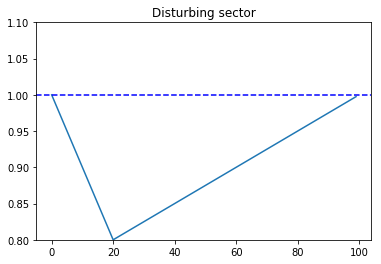

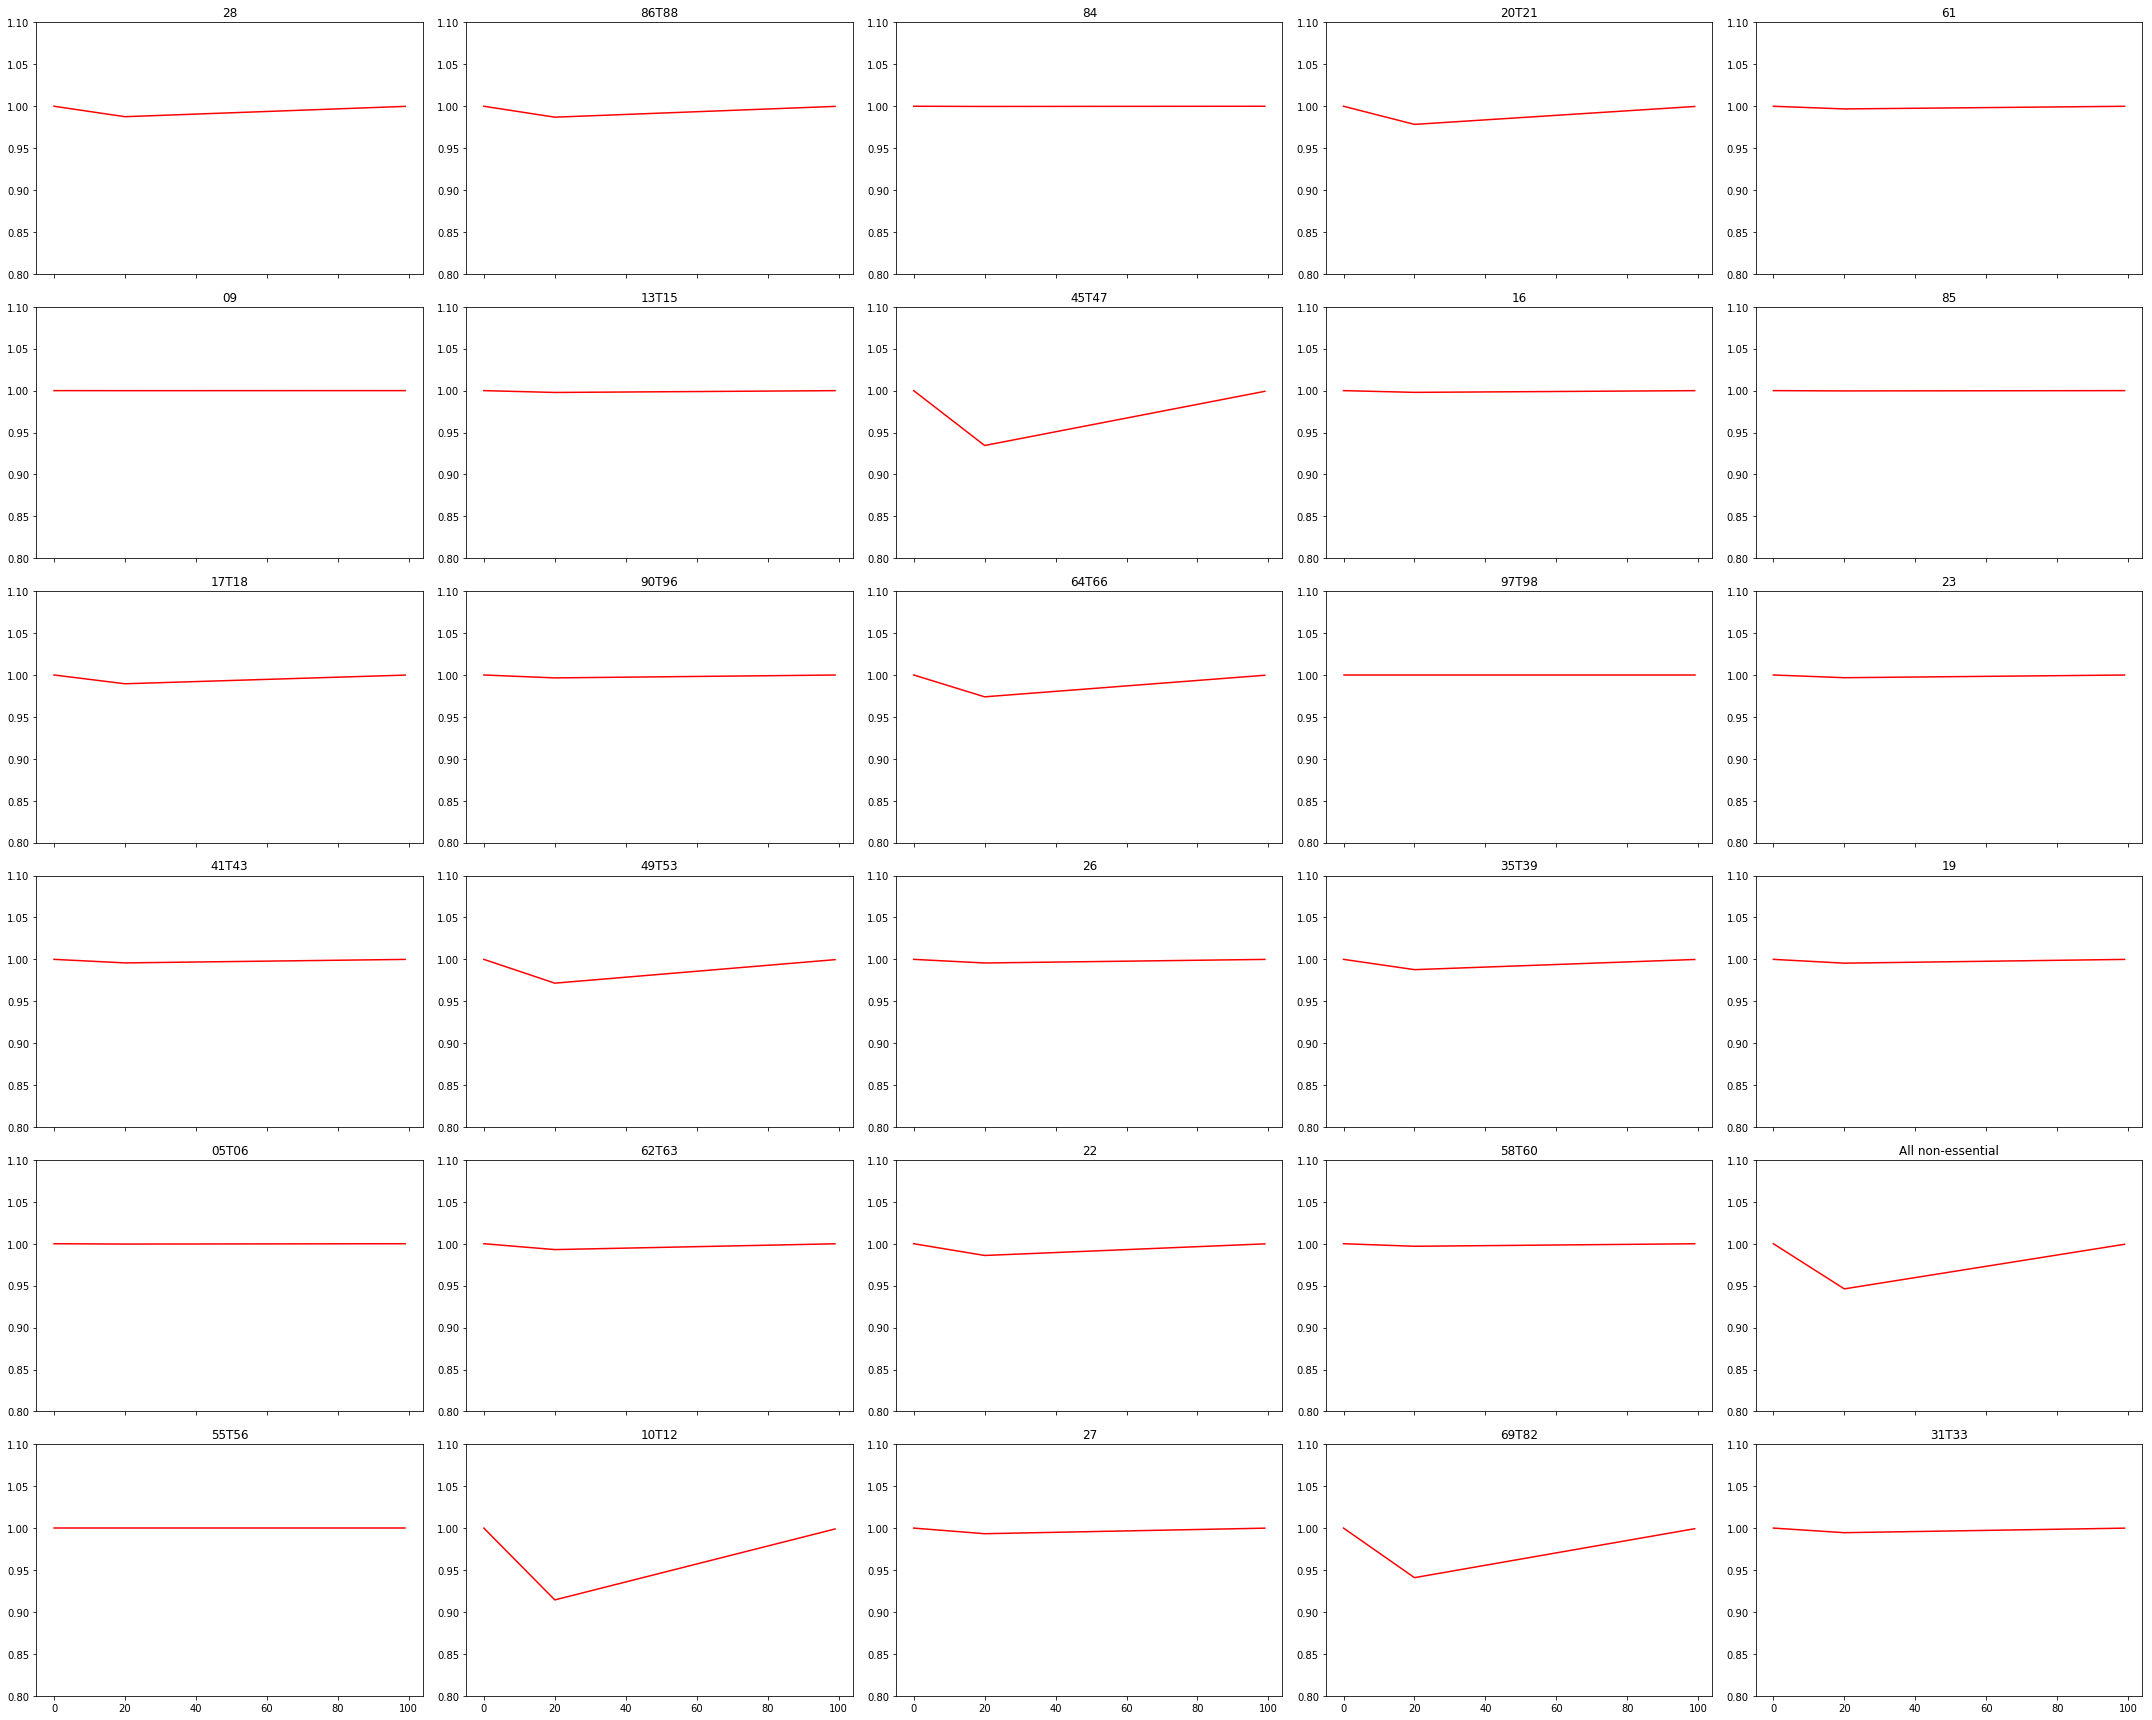

In [7]:
# Plot the exogeneous variables
import matplotlib.pyplot as plt

plt.figure()
plt.plot(1-exog_nodes_dict['55T56'])#Manufacture of basic metals
#help(plt.axhline)
plt.axhline(1,color='b',linestyle='--')
plt.ylim([0.8,1.1])
plt.title('Disturbing sector')


fig,ax = plt.subplots(6,5,figsize=(30,24),sharex=True)#(figsize=(12,8))
nodes = []
for _ax,node in zip(ax.flat,simulator.node_values.keys()):#simulator.node_values.keys():
    #if ctr < 100:
    #if len(simulator.node_values)>0:
    #plt.plot(np.hstack((1,simulator.node_values[node][1:])),c='r')
    _ax.plot(np.array(1-np.array(simulator.node_values[node][1:])),c='r')#/nx.get_node_attributes(simulator.sim_graph,'baseline')[node])
    #_ax.axhline(nx.get_node_attributes(simulator.sim_graph,'baseline')[node]/nx.get_node_attributes(simulator.sim_graph,'baseline')[node],color='r',linestyle='--')
    _ax.set_title(node)
    nodes.append(node)
    _ax.set_ylim([0.8,1.1])
plt.tight_layout()
    #else:
    #    break

In [245]:
class LeonTradeModel:
    
    def __init__(self,df_L):
        self.df_L = df_L
        self.country_indices, self.sector_indices = df_L.index.get_level_values(0).values, df_L.index.get_level_values(1).values
        self.countries, self.sectors = df_L.index.get_level_values(0).unique().values, df_L.index.get_level_values(1).unique().values
        
    def shock_sector(self,shock_val,country_code=None,sector_code=None):
        shock_vec = np.zeros(self.df_L.shape[0])
        if (sector_code is not None) & (country_code is not None):
            #print(self.countries)
            #print(np.where(self.countries==country_code)[0])
            shocked_val_idx = (np.where(self.countries==country_code)[0][0] * len(set(self.sectors))) + np.where(self.sectors==sector_code)[0][0]
            shock_vec[shocked_val_idx] = shock_val
        elif (sector_code is None) & (country_code is not None):
            shocked_val_idx = np.where(self.country_indices==country_code)[0]
            shock_vec[shocked_val_idx] = shock_val
        elif (country_code is None) & (sector_code is not None):
            shocked_val_idx = np.where(self.sector_indices==sector_code)[0]
            shock_vec[shocked_val_idx] = shock_val
        else:
            print('depressing world')
            shock_vec = np.ones(shock_vec.shape)*shock_val
        return shock_vec
    
    def simulate_shock(self,shock_vec,key='downstream'):
        if key=='downstream':
            return np.dot(self.df_L.values.T,shock_vec)
        else:
            return np.dot(self.df_L.values,shock_vec)
        
    
    #def aggregate_shock(self,shock_res,aggr_idx = 0):
    #    if (aggr_idx == 0):
    #        df_shock_res = 
        
        

network_model = LeonTradeModel(df_lev)
shock_vec = network_model.shock_sector(-0.99,'DEU','28')
network_model.simulate_shock(shock_vec)
print(sum(network_model.simulate_shock(shock_vec))/2015)

network_model = LeonTradeModel(df_lev)
shock_vec = network_model.shock_sector(-0.99,country_code='DEU')
network_model.simulate_shock(shock_vec)
print(sum(network_model.simulate_shock(shock_vec))/2015)

network_model = LeonTradeModel(df_lev)
shock_vec = network_model.shock_sector(-0.99,sector_code='28')
network_model.simulate_shock(shock_vec)
print(sum(network_model.simulate_shock(shock_vec))/2015)

network_model = LeonTradeModel(df_lev)
shock_vec = network_model.shock_sector(shock_val=-0.4)
network_model.simulate_shock(shock_vec,key='upstream')
print(sum(network_model.simulate_shock(shock_vec,key='upstream'))/2015)

-0.0007736255685369342
-0.061330168542207866
-0.04994463164988735
depressing world
-0.827900421406617


In [281]:
def produce_shocks(initial_shock,steps=30,ar_par=0.9,mean=0.003,sd=0.01):
    iid_shocks = np.random.normal(mean,sd,steps)
    predictions = [initial_shock]
    for i in range(steps):
        yhat = ar_par*predictions[-1] + iid_shocks[i]
        predictions.append(yhat)
    
    return predictions

def simulate_economic_dynamics(economic_network,external_shock,country_code,sector_code=None,t_sim=30):
    t_clock = 0
    global_shock_vec = []
    supply_shock_matrix,demand_shock_matrix = np.zeros((economic_network.df_L.shape[1],t_sim)),np.zeros((economic_network.df_L.shape[1],t_sim))
    shock_vec = economic_network.shock_sector(shock_val=external_shock[0],country_code=country_code,sector_code=sector_code)
    #shock_matrix_out[:,0] = shock_vec
    
    while(t_clock < t_sim):
        supply_shock = economic_network.simulate_shock(shock_vec,key='upstream')
        
        demand_shock = economic_network.simulate_shock(shock_vec,key='downstream')
        supply_shock[supply_shock>1] = 1
        demand_shock[demand_shock>1] = 1
        global_shock_vec.append(sum(supply_shock + demand_shock)/2015)
        demand_shock_matrix[:,t_clock] = demand_shock
        supply_shock_matrix[:,t_clock] = supply_shock
        
        t_clock = t_clock + 1
        shock_vec =0.9 * economic_network.shock_sector(shock_val=external_shock[t_clock],country_code=country_code,sector_code=sector_code) + 0.1*(supply_shock)
        #shock_vec =  (supply_shock+demand_shock)
        
        
    
    return global_shock_vec,demand_shock_matrix,supply_shock_matrix

def simulate_economic_dynamics_recursive(economic_network,initial_shock,country_code,sector_code=None,t_sim=30):
    t_clock = 0
    shock_vec_old = economic_network.shock_sector(shock_val=initial_shock,country_code=country_code,sector_code=sector_code)
    global_shock_vec = []
    while(t_clock < t_sim):
        shock_vec_new = economic_network.simulate_shock(shock_vec_old)
        global_shock_vec.append(sum(shock_vec_new)/2015)
        t_clock = t_clock + 1
        shock_vec_old = shock_vec_new
        
        
    
    return global_shock_vec

network_model = LeonTradeModel(df_lev)
external_shock = produce_shocks(-0.1)
res,demand_shock_matrix, supply_shock_matrix = simulate_economic_dynamics(network_model,external_shock=external_shock,country_code='DEU',sector_code='28')

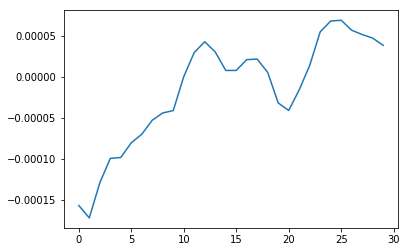

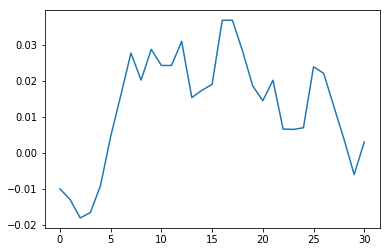

In [282]:
plt.plot(res[0:100])
plt.figure()
plt.plot(initial_shock)

In [284]:
(supply_shock_matrix[:,10][0:100])

array([-1.65513491e-07, -7.50775035e-08, -1.06860408e-08, -3.56504700e-08,
       -1.75855653e-08, -1.32395373e-08, -2.78507674e-08, -7.18369746e-08,
       -5.06095042e-08, -3.58403519e-08, -1.18497232e-08, -1.83824715e-09,
       -1.05693965e-08, -5.70553663e-09, -1.37866997e-09, -2.50908309e-08,
       -2.06244913e-09, -1.36638163e-07, -5.92935021e-08, -8.32953338e-09,
       -2.32613581e-08, -8.95434818e-09, -7.89791501e-09, -3.44427970e-08,
       -8.35987202e-08, -2.46917197e-10, -1.98184642e-10, -8.93841172e-09,
       -5.64426223e-09,  0.00000000e+00, -1.44109109e-07, -3.39975402e-07,
       -6.94657521e-08, -5.64896631e-08, -8.32981879e-09, -1.69427023e-08,
       -2.90139860e-08, -3.16904197e-08, -4.95993716e-08, -2.26090936e-08,
       -1.88494338e-08, -1.65566950e-08, -8.13393090e-09, -1.56257536e-08,
       -4.30676435e-09, -1.44516431e-07, -2.32666554e-07, -3.61486622e-07,
       -3.57234192e-07, -6.31069834e-08, -3.03878852e-08, -7.33106421e-08,
       -8.37060947e-08, -

In [248]:
# write a fn. that writes the following schema 
# country, sector, time, value
# saving the filem into venus as sun(oecd data) --> mercury (L matrix) --> venus (current output)
fh = open('/project_data/data_asset/venus/ws3/oecd_econsim_trigger_DEU_28.csv','wt')
fh.write('country,sector,time,demanddelta,supplydelta\n')
for _time in range(30):
    ctr = 0
    for _country, _sector in zip(network_model.df_L.index.get_level_values(0).values,network_model.df_L.index.get_level_values(1).values):
        fh.write('%s,%s,%s,%s,%s\n'%(_country,_sector,_time+1,demand_shock_matrix[ctr,_time],supply_shock_matrix[ctr,_time]))
        ctr += 1
fh.close()
        
    
# should have 2015*30 entries

In [ ]:
from statsmodels.tsa.arima_process import ArmaProcess
shock_ar = ArmaProcess(ar=np.array([1,-0.99,-0.005]),ma=np.array([1,0.1])).generate_sample(100)
plt.plot(shock_ar)
#plt.scatter(shock_ar[:99],shock_ar[1:])

In [ ]:
##Some Leonrtuief matrix checks
#L_De = df_lev.values#.loc['DEU'].values
#L_De_inv = np.linalg.pinv(L_De)
#np.sum(np.eye(L_De.shape[0])-np.linalg.pinv(L_De),axis=0)

In [ ]:
np.sum(np.eye(L_De.shape[0])-L_De_inv,axis=1)

- How come the row sums are not 1? (with or without All non-essential). Scaling missing?
- Which table should be used for building the network graph?

In [ ]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sbs

np.random.seed(42)
%matplotlib inline

import pandas as pd
df_iots = pd.read_csv('/project_data/data_asset/IO_WORLD_LONG.csv')#sun/economy/IOTSI4_2018_Domestic.csv

def build_economic_flow_cell(_df):
    '''
    Function to model economic activity flow within a cell as an attributed graph
    '''
    G = nx.DiGraph()
    activity = list(set(list(_df['output_sector'].values) + list(_df['input_sector'].values)))
    #print(activity)
    G.add_nodes_from(activity)
    
    nx.set_node_attributes(G,lambda *x: sum(x),name='fn')
    #nx.set_node_attributes(G,None,name=1)
    print(len(_df))
    for index,row in _df.iterrows():
        if (index%1000 == 0):
            print(index)
        _df_outgoing = _df[(_df['output_sector']==row['output_sector']) & (_df['output_country']==row['output_country'])]
        try:
            _scale_factor = row['value']/sum(_df_outgoing['value'])
            G.add_edge(row['output_sector'],row['input_sector'])
            nx.set_edge_attributes(G,{(row['output_sector'],row['input_sector']):{'val':_scale_factor/100}})
            #print('scaling')
        except Exception as e:
            print('should not happen %s'%(e))
            _scale_factor = 0.1
                               
            
    
    return G

# Consider that for Australia

_df = df_iots[(df_iots['output_country']=='GBR')]

econ_flow = build_economic_flow_cell(_df)

try:
    from pyvis.network import Network
    interactive = True
except:
    try:
        !pip install pyvis
        !pip install jsonpickle
        from pyvis.network import Network
        interactive = True
    except:
        interactive = False

if interactive:
    g = Network(height=800,width=600,notebook=True)
    g.toggle_hide_edges_on_drag(True)
    g.barnes_hut()
    g.from_nx(econ_flow)
    try:
        g.show('gr1.html')
    except:
        options = {
        'node_color': 'black',
        'node_size': 50,
        'line_color': 'grey',
        'linewidths': 0,
        'width': 0.1,}
        plt.figure(figsize=(24,12))
        nx.draw(econ_flow,pos=nx.random_layout(econ_flow),**options)
        plt.show()
else:
    options = {
    'node_color': 'black',
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,}
    plt.figure(figsize=(24,12))
    nx.draw(econ_flow,pos=nx.random_layout(econ_flow),**options)
    plt.show()
    
plt.show()
sbs.heatmap(nx.adjacency_matrix(econ_flow,weight='val').toarray())
#print(list(econ_flow_aus.nodes()))


In [ ]:
io_mat = nx.adjacency_matrix(econ_flow,weight='val').toarray()

In [ ]:
np.sum(io_mat,axis=1),np.sum(io_mat,axis=0)

In [ ]:
df_iots

In [ ]:
list(df_lev.loc['sector'].columns)

In [ ]:
np.dot(np.eye(3).T,np.array([10,2,3]))